`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


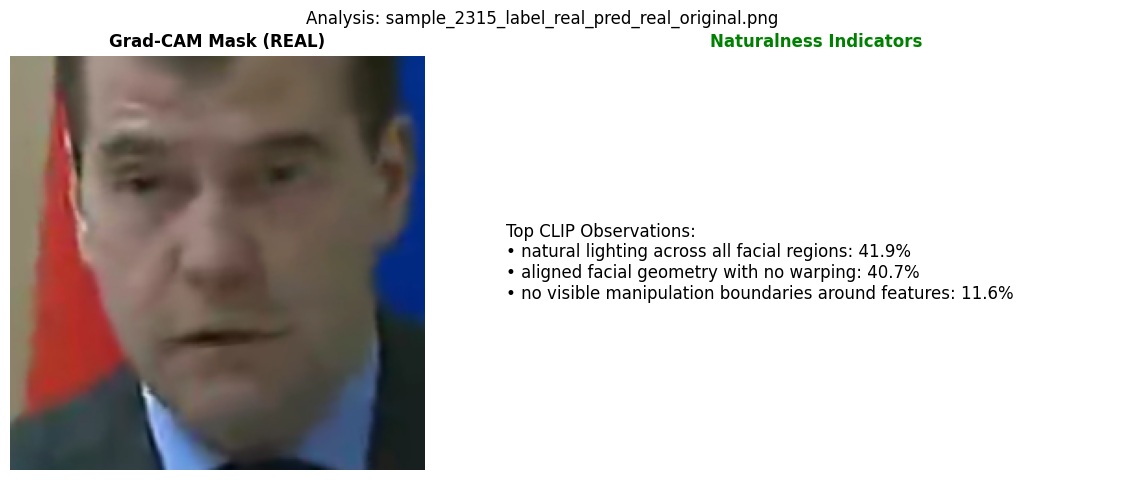

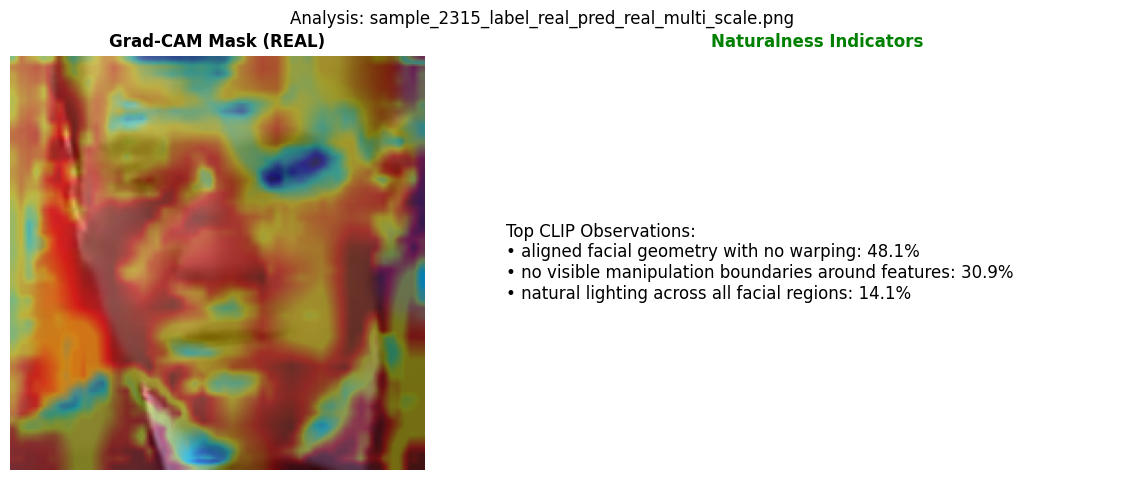

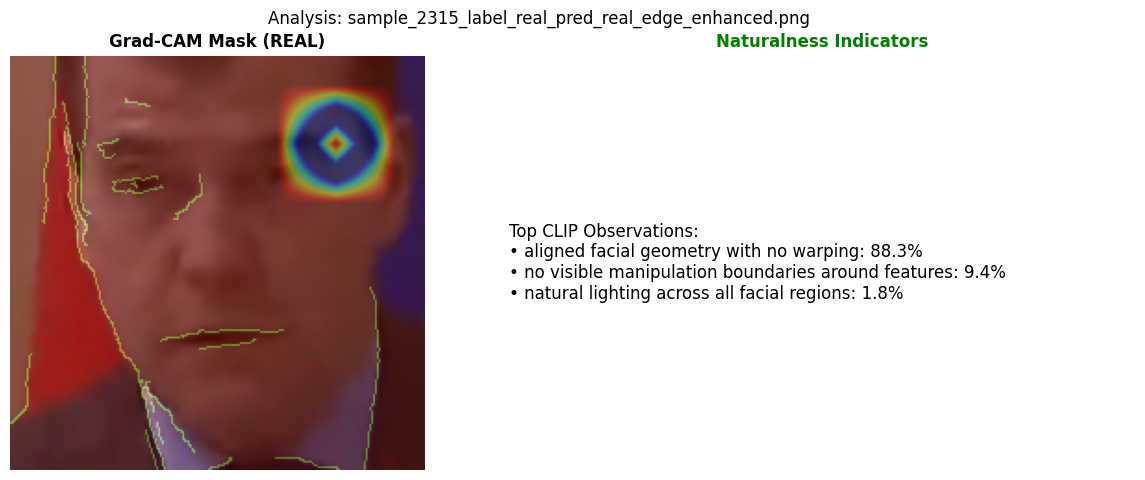

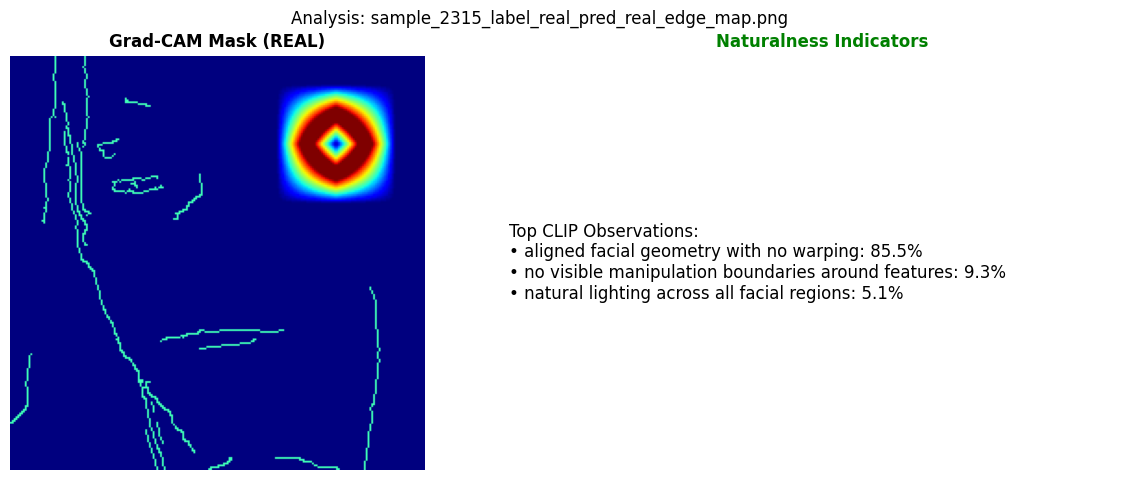

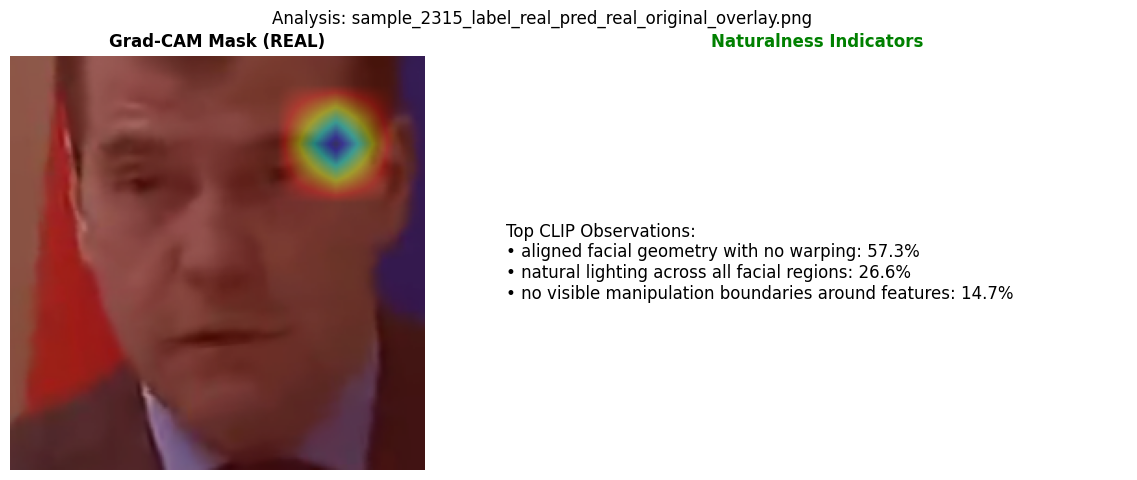

In [36]:
import glob
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

# Initialize CLIP
model = CLIPModel.from_pretrained("/mnt/workspace/clip-vit-large-patch14-336")
processor = CLIPProcessor.from_pretrained(model.config.name_or_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Specialized prompts for real/fake analysis
real_prompts = [
    "consistent skin texture with no sharp transitions",
    "natural lighting across all facial regions",
    "no visible manipulation boundaries around features",
    "aligned facial geometry with no warping",
    "realistic hair and skin interaction"
]

fake_prompts = [
    "blurry artifacts around mouth or eyes",
    "unnatural texture patterns on cheeks or forehead",
    "visible seams between manipulated and unaltered regions",
    "mismatched lighting on different parts of the face",
    "warped facial features inconsistent with anatomy"
]

# Process all masks
for mask_path in glob.glob("/mnt/workspace/attention_results/sample_23*.png"):
    try:
        # Extract label from filename
        filename = mask_path.split('/')[-1]
        is_real = "label_real" in filename
        
        # Select appropriate prompts
        prompts = real_prompts if is_real else fake_prompts
        label = "REAL" if is_real else "FAKE"
        
        # CLIP inference
        image = Image.open(mask_path)
        inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            probs = model(**inputs).logits_per_image.softmax(dim=1)
        
        # Get top 3 predictions
        top3_conf, top3_idx = torch.topk(probs[0], 3)
        descriptions = [f"{prompts[i]}: {c:.1%}" for i, c in zip(top3_idx, top3_conf)]
        
        # Visualization
        plt.figure(figsize=(13, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Grad-CAM Mask ({label})", fontweight='bold')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        desc_text = "\n".join([f"• {d}" for d in descriptions])
        plt.text(0, 0.5, 
                f"Top CLIP Observations:\n{desc_text}",
                fontsize=12, va='center')
        plt.axis('off')
        plt.title("Anomaly Description" if label=="FAKE" else "Naturalness Indicators", 
                 fontweight='bold', color='red' if label=="FAKE" else 'green')
        
        plt.suptitle(f"Analysis: {filename}", y=0.95)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Skipped {filename}: {str(e)}")

The code above does not know the existence of attention map and regards the map as part of the image. 
Let's try mentioning the attention map in the prompt.

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
2025-07-21 23:55:31.517491: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 23:55:31.969227: E tensorflow/c

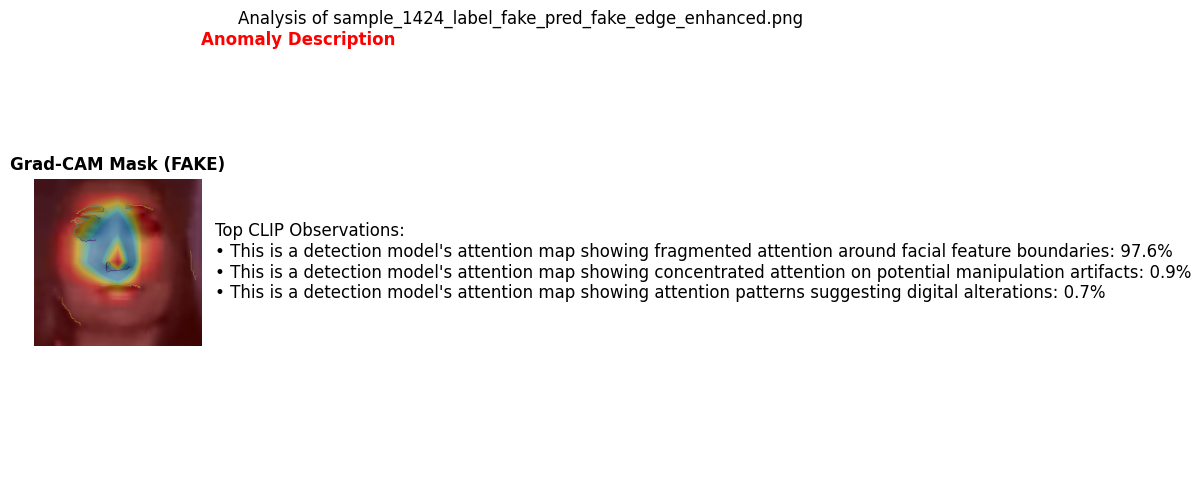

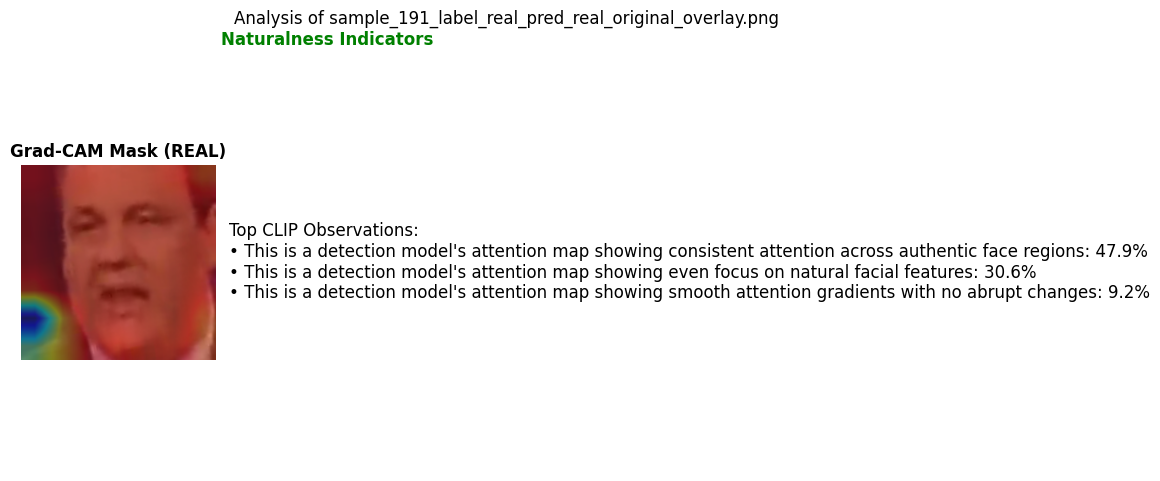

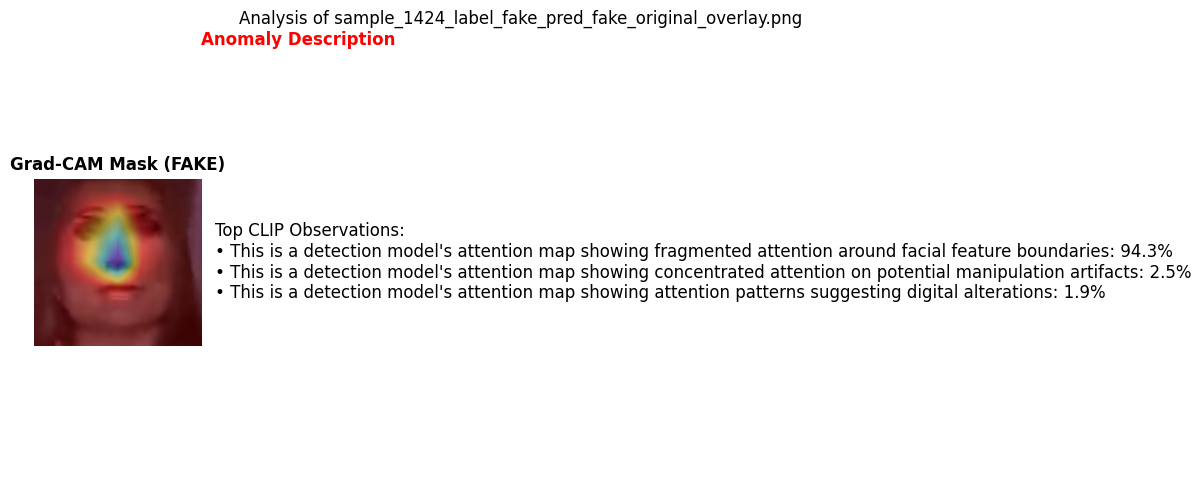

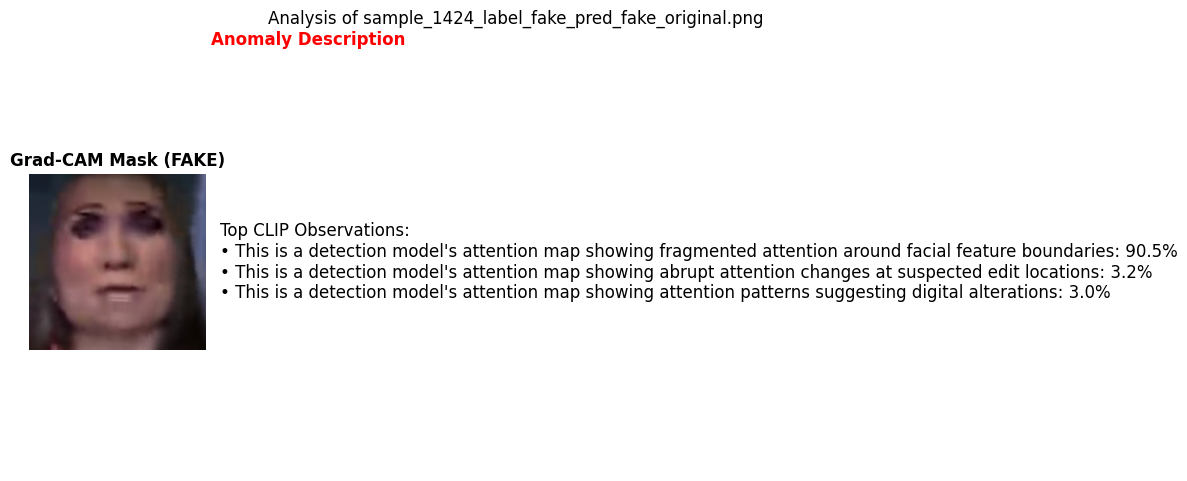

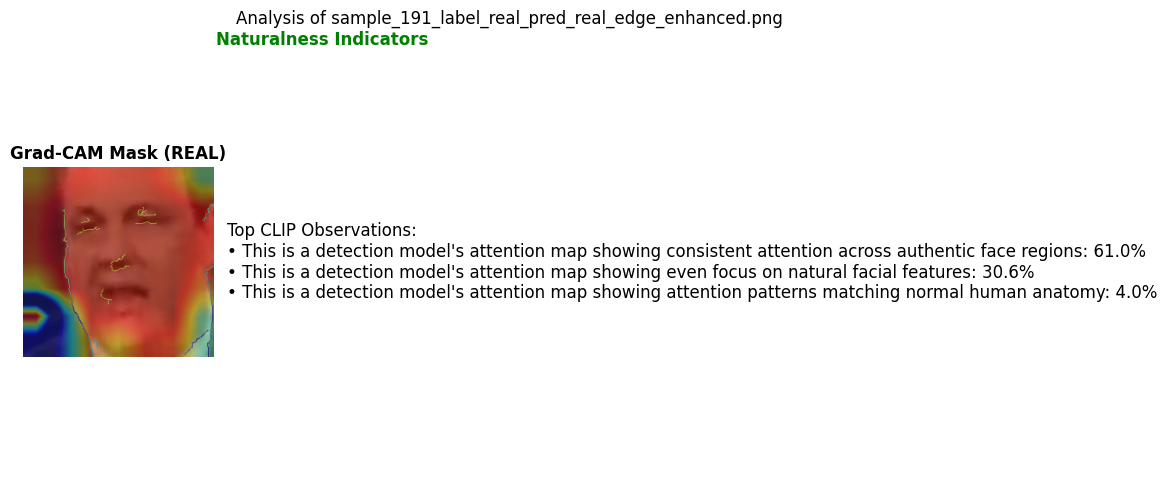

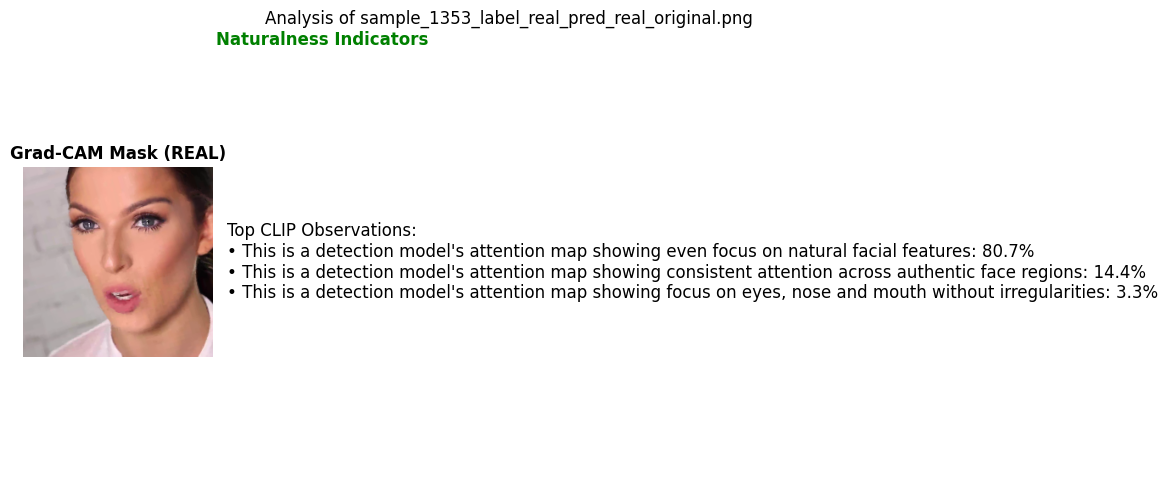

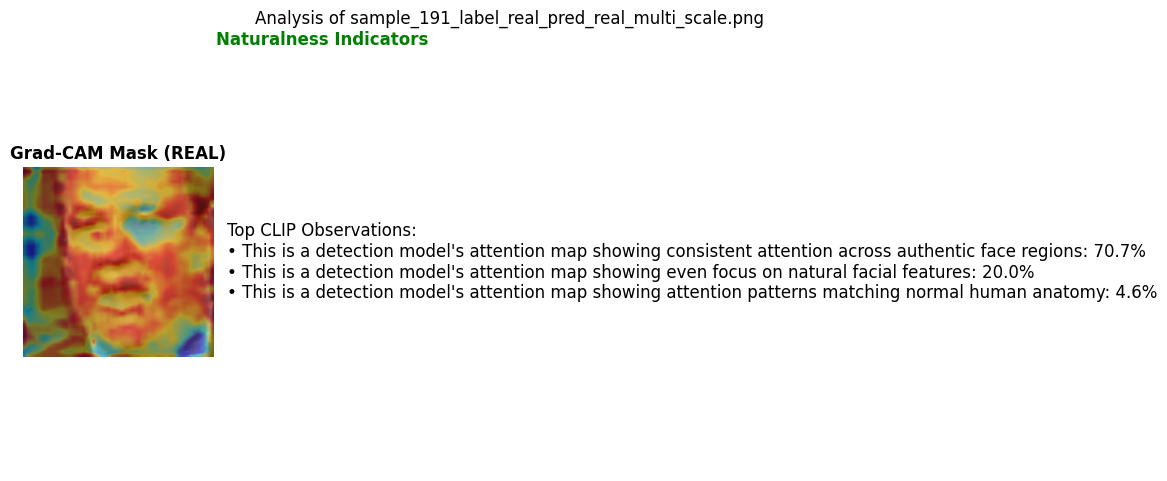

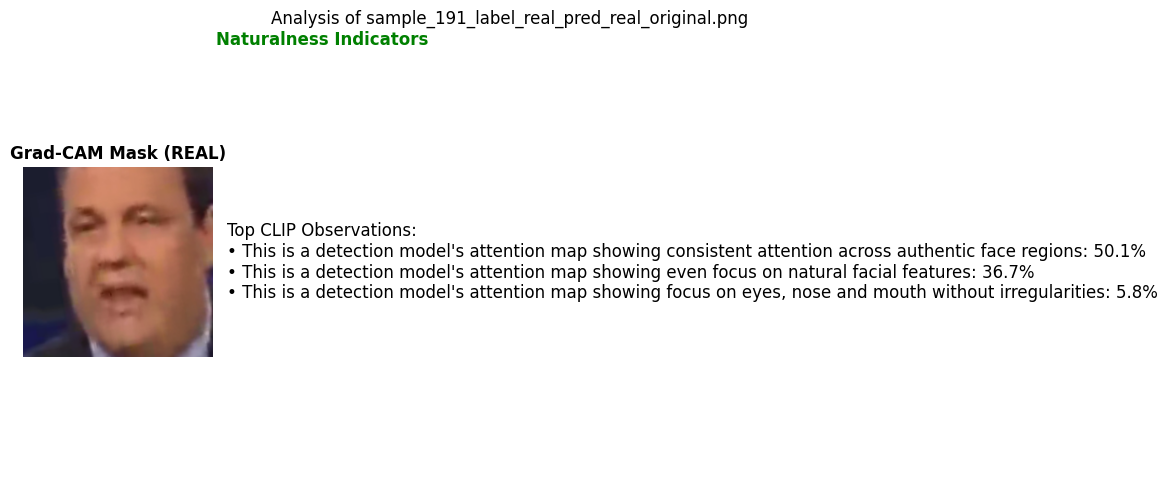

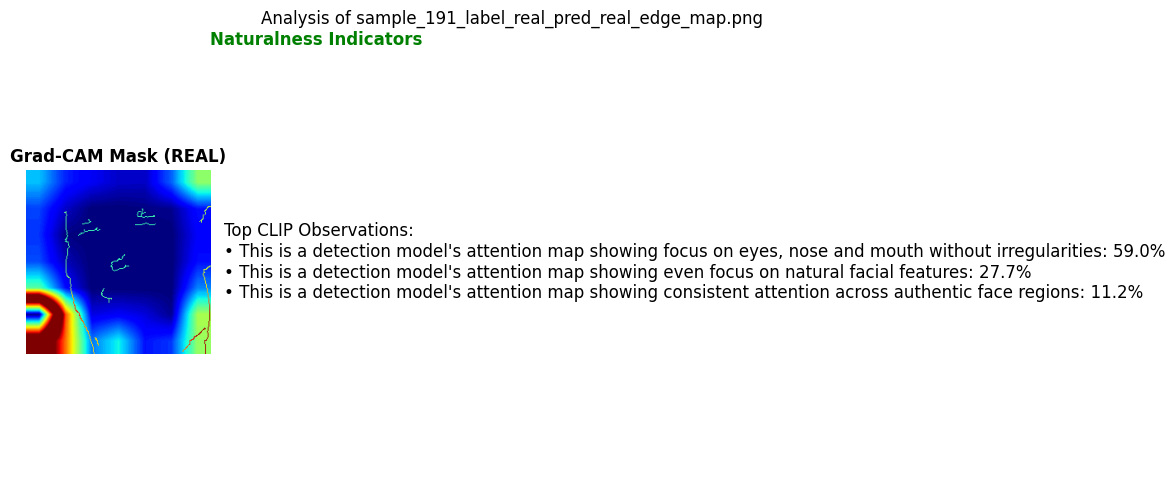

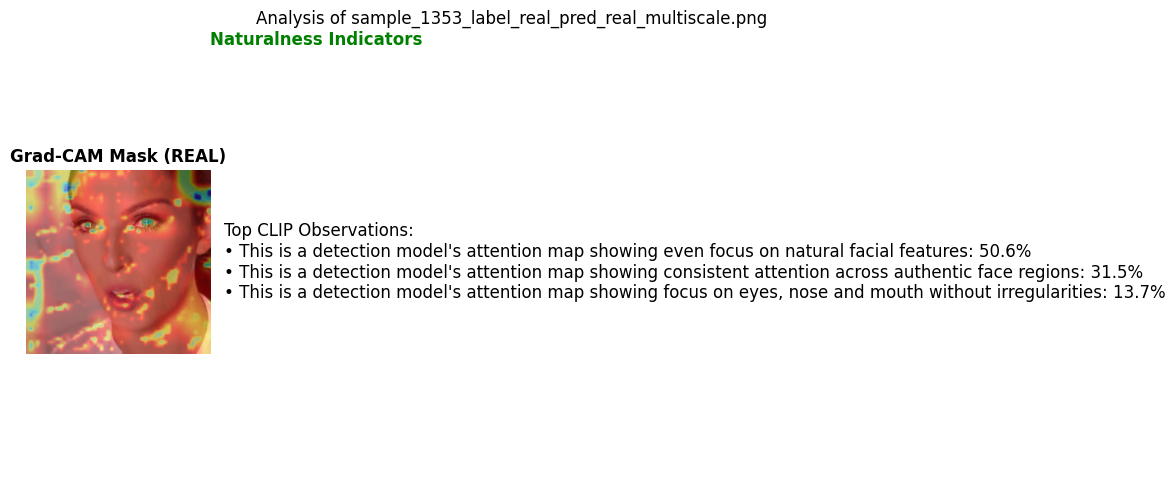

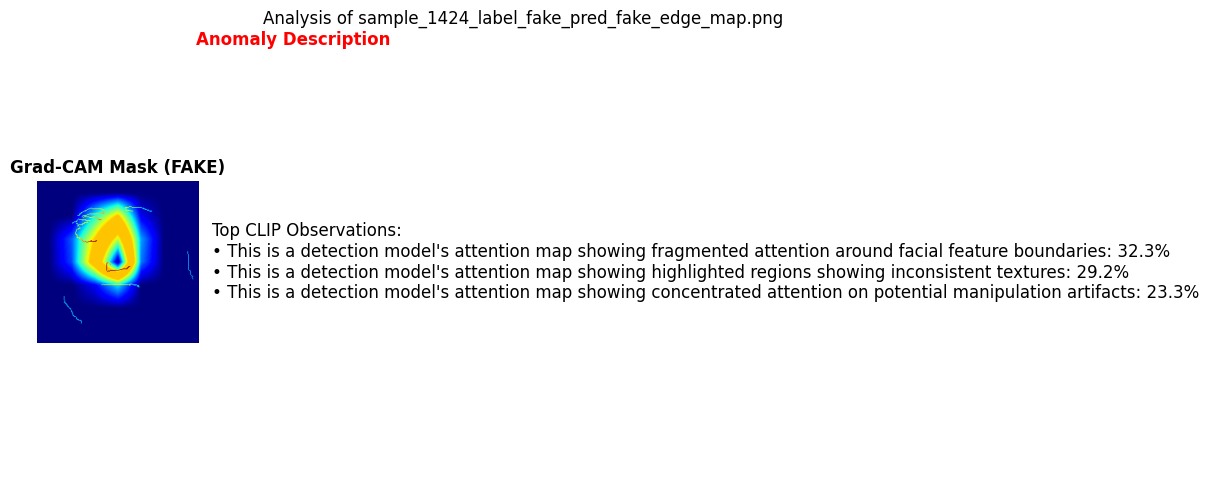

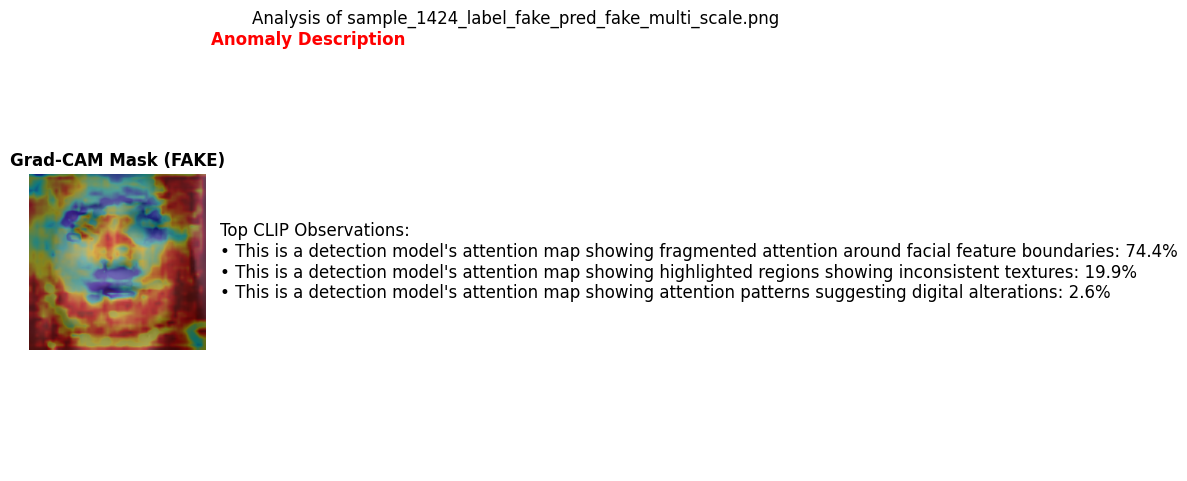

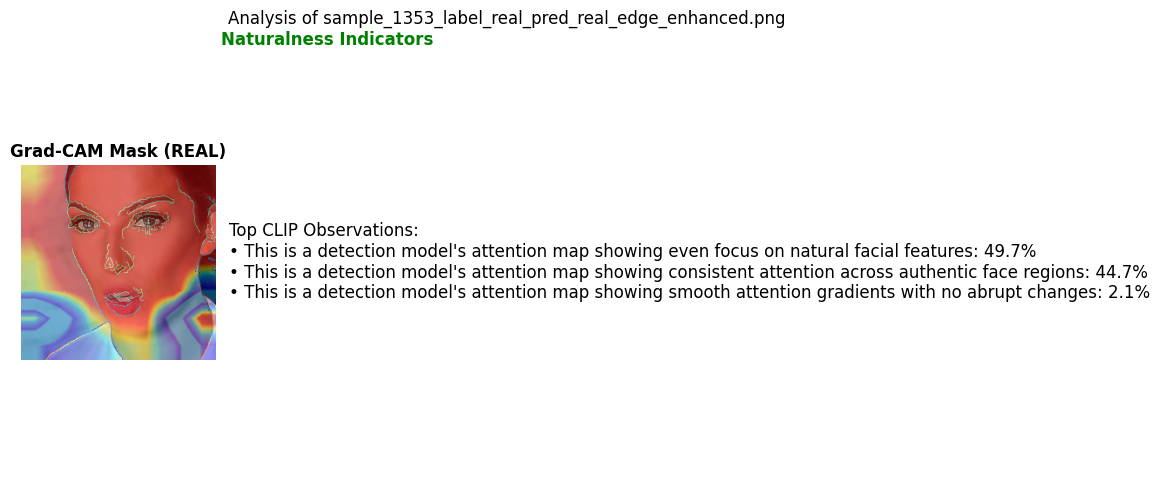

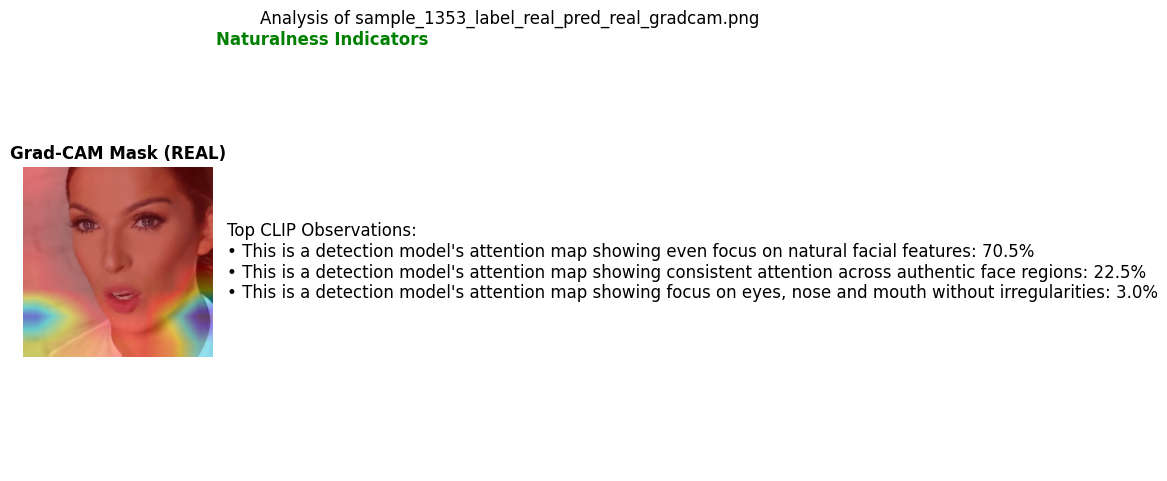

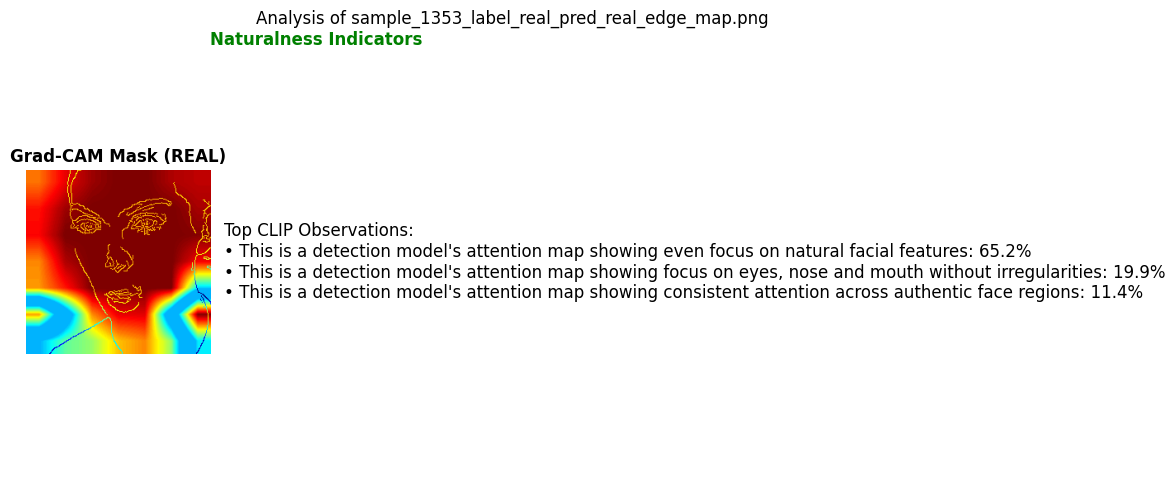

In [1]:
import glob
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

# Initialize CLIP
model = CLIPModel.from_pretrained("/mnt/workspace/clip-vit-large-patch14-336")
processor = CLIPProcessor.from_pretrained(model.config.name_or_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess_mask(mask):
    """Convert attention mask to be more interpretable for CLIP"""
    # Convert to numpy array
    mask_np = np.array(mask)
    
    # Normalize and apply color mapping
    if len(mask_np.shape) == 2:  # Grayscale
        mask_np = (mask_np - mask_np.min()) / (mask_np.max() - mask_np.min() + 1e-8)
        mask_np = (mask_np * 255).astype(np.uint8)
        mask = Image.fromarray(mask_np).convert('RGB')
    
    return mask

def get_mask_type(filename):
    """Extract mask type from filename"""
    if 'edge_map' in filename:
        return "Edge Map"
    elif 'edge_enhanced' in filename:
        return "Enhanced Edge Map"
    elif 'multi_scale' in filename:
        return "Multi-Scale Attention"
    elif 'original_overlay' in filename:
        return "Overlay Heatmap"
    elif 'comparison' in filename:
        return "Comparison Map"
    elif 'original' in filename:
        return "Original Image"
    else:
        return "Attention Map"



# Context-aware prompts with mask-specific language
mask_context = "This is a detection model's attention map showing "

real_prompts = [
    mask_context + "even focus on natural facial features",
    mask_context + "consistent attention across authentic face regions",
    mask_context + "attention patterns matching normal human anatomy",
    mask_context + "smooth attention gradients with no abrupt changes",
    mask_context + "focus on eyes, nose and mouth without irregularities"
]

fake_prompts = [
    mask_context + "concentrated attention on potential manipulation artifacts",
    mask_context + "abrupt attention changes at suspected edit locations",
    mask_context + "fragmented attention around facial feature boundaries",
    mask_context + "highlighted regions showing inconsistent textures",
    mask_context + "attention patterns suggesting digital alterations"
]

# Process all masks
for mask_path in glob.glob("/mnt/workspace/attention_results1/*.png"):
    try:
        # Extract label from filename
        filename = mask_path.split('/')[-1]
        is_real = "label_real" in filename
        mask_type = get_mask_type(filename)
        
        # Select appropriate prompts
        prompts = real_prompts if is_real else fake_prompts
        label = "REAL" if is_real else "FAKE"
        
        # Load and preprocess mask
        image = Image.open(mask_path)
        image = preprocess_mask(image)
        
        # CLIP inference
        inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            probs = model(**inputs).logits_per_image.softmax(dim=1)
        
        # Get top predictions
        top_conf, top_idx = torch.max(probs[0], 0)
        top_desc = prompts[top_idx]

        # Get top 3 predictions
        top3_conf, top3_idx = torch.topk(probs[0], 3)
        descriptions = [f"{prompts[i]}: {c:.1%}" for i, c in zip(top3_idx, top3_conf)]
        
        # Visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Grad-CAM Mask ({label})", fontweight='bold')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        desc_text = "\n".join([f"• {d}" for d in descriptions])
        plt.text(0, 0.5, 
                f"Top CLIP Observations:\n{desc_text}",
                fontsize=12, va='center')
        plt.axis('off')

        
        # # Visualization
        # plt.figure(figsize=(10, 5))
        
        # # Show original mask
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.title(f"{mask_type} ({label})", fontsize=10, pad=10)
        # plt.axis('off')
        
        # # Show analysis
        # plt.subplot(1, 2, 2)
        # analysis_text = f"Model Interpretation:\n{top_desc}\n\nConfidence: {top_conf:.1%}"
        # plt.text(0.1, 0.5, analysis_text, 
        #         fontsize=10, va='center', linespacing=1.5)
        # plt.axis('off')
        plt.title("Anomaly Description" if label=="FAKE" else "Naturalness Indicators", 
         fontweight='bold', color='red' if label=="FAKE" else 'green')
        
        plt.suptitle(f"Analysis of {filename}", y=0.95, fontsize=12)
        plt.tight_layout(pad=1.0)
        plt.show()
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Author

**Choo Lee Wen**